In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import re # for regex
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import SnowballStemmer
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.metrics import accuracy_score
import pickle
import requests
from bs4 import BeautifulSoup
import nltk

In [7]:
import requests
from bs4 import BeautifulSoup
import pandas as pd

start_url = 'https://www.imdb.com/title/tt1517268/reviews/?ref_=tt_ql_2'
link = 'https://www.imdb.com/title/tt1517268/reviews/_ajax'

params = {
    'ref_': 'undefined',
    'paginationKey': ''
}

reviews_list = []

with requests.Session() as s:
    s.headers['User-Agent'] = 'Mozilla/5.0 (Windows NT 6.1) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/88.0.4324.150 Safari/537.36'
    res = s.get(start_url)

    while True:
        soup = BeautifulSoup(res.text, "lxml")
        for item in soup.select(".review-container"):
            review_text = item.select_one(".text.show-more__control").get_text(strip=True)
            rating = item.select_one(".ipl-ratings-bar").text.strip() if item.select_one(".ipl-ratings-bar") else None
            reviews_list.append({'Review': review_text, 'Rating': rating})

        try:
            pagination_key = soup.select_one(".load-more-data[data-key]").get("data-key")
        except AttributeError:
            break
        params['paginationKey'] = pagination_key
        res = s.get(link, params=params)

# Convert the list of reviews into a DataFrame
df = pd.DataFrame(reviews_list)

# Print the DataFrame
print(df)

# Optionally, you can save the DataFrame to a CSV file
df.to_csv('imdb_reviews.csv', index=False)


                                                 Review Rating
0     Margot does the best with what she's given, bu...   6/10
1     Before making Barbie (2023),Greta Gerwigsingle...   6/10
2     The first reason to go see it:It's good fun. I...   7/10
3     As much as it pains me to give a movie called ...  10/10
4     As a woman that grew up with Barbie, I was ver...   6/10
...                                                 ...    ...
1472  I'm NOT a Barbie girl in NOT the Barbie World,...   5/10
1473  The movie is mediocre at best. I expected an o...   3/10
1474  Some things were super clever and made me laug...   5/10
1475  For sure It failed to achieve feminism or be a...   5/10
1476  Barbie is cute, creative and fun. The acting i...   5/10

[1477 rows x 2 columns]


In [8]:
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/navyaprasad/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

In [9]:
# Initialize the sentiment intensity analyzer
sia = SentimentIntensityAnalyzer()

# Define a function to get the sentiment of a review
def get_sentiment(review):
    sentiment = sia.polarity_scores(review)
    return sentiment['compound']  # return the compound score which is a single number representing the sentiment

# Apply the function to the 'Review' column of the DataFrame
df['Sentiment'] = df['Review'].apply(get_sentiment)

In [10]:
df['Rating'] = df['Rating'].str.extract('(\d+)')

# Convert the 'Rating' column to numeric
df['Rating'] = pd.to_numeric(df['Rating'], errors='coerce')



In [11]:
df['Rating_Sentiment_Product'] = df['Rating'] * df['Sentiment']

In [13]:
df = df.dropna(subset=['Rating_Sentiment_Product'])

In [14]:
df.head()

,Review,Rating,Sentiment,Rating_Sentiment_Product
0,"Margot does the best with what she's given, bu...",6.0,0.9235,5.5410
1,"Before making Barbie (2023),Greta Gerwigsingle...",6.0,0.9811,5.8866
2,The first reason to go see it:It's good fun. I...,7.0,0.9970,6.9790
3,As much as it pains me to give a movie called ...,10.0,0.9898,9.8980
4,"As a woman that grew up with Barbie, I was ver...",6.0,0.7497,4.4982


In [15]:
# Define a function to categorize based on the 'Rating_Sentiment_Product' column
def categorize_combined(product):
    if pd.isna(product):  
        return 'Not Rated'

    if product >= 8:
        return 'Strong Positive'
    elif product >= 6:
        return 'Positive'
    elif product >= 0:
        return 'Neutral'
    elif product >= -3:
        return 'Negative'
    else:
        return 'Strong Negative'

# Apply the categorization function to create a new column
df['Sentiment_Category'] = df['Rating_Sentiment_Product'].apply(categorize_combined)


In [16]:
df

,Review,Rating,Sentiment,Rating_Sentiment_Product,Sentiment_Category
0,"Margot does the best with what she's given, bu...",6.0,0.9235,5.5410,Neutral
1,"Before making Barbie (2023),Greta Gerwigsingle...",6.0,0.9811,5.8866,Neutral
2,The first reason to go see it:It's good fun. I...,7.0,0.9970,6.9790,Positive
3,As much as it pains me to give a movie called ...,10.0,0.9898,9.8980,Strong Positive
4,"As a woman that grew up with Barbie, I was ver...",6.0,0.7497,4.4982,Neutral
...,...,...,...,...,...
1472,"I'm NOT a Barbie girl in NOT the Barbie World,...",5.0,0.4098,2.0490,Neutral
1473,The movie is mediocre at best. I expected an o...,3.0,0.9161,2.7483,Neutral
1474,Some things were super clever and made me laug...,5.0,0.8873,4.4365,Neutral
1475,For sure It failed to achieve feminism or be a...,5.0,0.9709,4.8545,Neutral


In [17]:
df.Sentiment_Category.value_counts()

Neutral            475
Strong Positive    462
Positive           386
Negative            94
Strong Negative     39
Name: Sentiment_Category, dtype: int64

In [18]:
!pip install imbalanced-learn

In [19]:
selected_columns = ['Review', 'Sentiment_Category']

# Create a new DataFrame with selected columns
data = df[selected_columns]

# Display the new DataFrame
data.head()

,Review,Sentiment_Category
0,"Margot does the best with what she's given, bu...",Neutral
1,"Before making Barbie (2023),Greta Gerwigsingle...",Neutral
2,The first reason to go see it:It's good fun. I...,Positive
3,As much as it pains me to give a movie called ...,Strong Positive
4,"As a woman that grew up with Barbie, I was ver...",Neutral


In [20]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1456 entries, 0 to 1476
Data columns (total 2 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Review              1456 non-null   object
 1   Sentiment_Category  1456 non-null   object
dtypes: object(2)
memory usage: 34.1+ KB


In [21]:
data.Sentiment_Category.value_counts()

Neutral            475
Strong Positive    462
Positive           386
Negative            94
Strong Negative     39
Name: Sentiment_Category, dtype: int64

In [22]:
!pip install imbalanced-learn


In [40]:
from imblearn.over_sampling import RandomOverSampler

# Define the features and target variable
X = data['Review']
y = data['Sentiment_Category']

# Initialize the oversampler
oversampler = RandomOverSampler(random_state=42)

# Resample the data
X_resampled, y_resampled = oversampler.fit_resample(X.values.reshape(-1, 1), y)

# Create a new DataFrame with the resampled data
balanced_data = pd.DataFrame({'Review': X_resampled.flatten(), 'Sentiment_Category': y_resampled})

# Print the count of each unique value in the 'Sentiment_Category' column
print(balanced_data['Sentiment_Category'].value_counts())


Neutral            475
Positive           475
Strong Positive    475
Strong Negative    475
Negative           475
Name: Sentiment_Category, dtype: int64


In [41]:
balanced_data.Sentiment_Category.replace('strong positive',2,inplace=True)
balanced_data.Sentiment_Category.replace('positive',1,inplace=True)
balanced_data.Sentiment_Category.replace('neutral',0,inplace=True)
balanced_data.Sentiment_Category.replace('negative',-1,inplace=True)
balanced_data.Sentiment_Category.replace('strong negative',-2,inplace=True)
balanced_data.head(10)

,Review,Sentiment_Category
0,"Margot does the best with what she's given, bu...",Neutral
1,"Before making Barbie (2023),Greta Gerwigsingle...",Neutral
2,The first reason to go see it:It's good fun. I...,Positive
3,As much as it pains me to give a movie called ...,Strong Positive
4,"As a woman that grew up with Barbie, I was ver...",Neutral
5,"It pains me to say it, but I enjoyed this movi...",Positive
6,I don't know if I put spoilers in here. I am s...,Neutral
7,I thought this would be so much different. The...,Strong Negative
8,"The quality, the humor, and the writing of the...",Neutral
9,"I went to see this today, everyone in my group...",Neutral


In [26]:
balanced_data.Review[0]

'Margot does the best with what she\'s given, but this film was very disappointing to me. It was marketed as a fun, quirky satire with homages to other movies. It started that way, but ended with over-dramatized speeches and an ending that clearly tried to make the audience feel something, but left everyone just feeling confused. And before you say I\'m a crotchety old man, I\'m a woman in my 20s, so I\'m pretty sure I\'m this movie\'s target audience. The saddest part is there were parents with their kids in the theater that were victims of the poor marketing, because this is not a kid\'s movie. Overall, the humor was fun on occasion and the film is beautiful to look at, but the whole concept falls apart in the second half of the film and becomes a pity party for the "strong" woman.'

In [27]:
def clean(text):
    cleaned = re.compile(r'<.*?>')
    return re.sub(cleaned,'',text)

balanced_data.Review = balanced_data.Review.apply(clean)
balanced_data.Review[0]

'Margot does the best with what she\'s given, but this film was very disappointing to me. It was marketed as a fun, quirky satire with homages to other movies. It started that way, but ended with over-dramatized speeches and an ending that clearly tried to make the audience feel something, but left everyone just feeling confused. And before you say I\'m a crotchety old man, I\'m a woman in my 20s, so I\'m pretty sure I\'m this movie\'s target audience. The saddest part is there were parents with their kids in the theater that were victims of the poor marketing, because this is not a kid\'s movie. Overall, the humor was fun on occasion and the film is beautiful to look at, but the whole concept falls apart in the second half of the film and becomes a pity party for the "strong" woman.'

In [28]:
def is_special(text):
    rem = ''
    for i in text:
        if i.isalnum():
            rem = rem + i
        else:
            rem = rem + ' '
    return rem

In [29]:
balanced_data.Review = balanced_data.Review.apply(is_special)
balanced_data.Review[0]

'Margot does the best with what she s given  but this film was very disappointing to me  It was marketed as a fun  quirky satire with homages to other movies  It started that way  but ended with over dramatized speeches and an ending that clearly tried to make the audience feel something  but left everyone just feeling confused  And before you say I m a crotchety old man  I m a woman in my 20s  so I m pretty sure I m this movie s target audience  The saddest part is there were parents with their kids in the theater that were victims of the poor marketing  because this is not a kid s movie  Overall  the humor was fun on occasion and the film is beautiful to look at  but the whole concept falls apart in the second half of the film and becomes a pity party for the  strong  woman '

In [30]:
def to_lower(text):
    return text.lower()

balanced_data.Review = balanced_data.Review.apply(to_lower)
balanced_data.Review[0]

'margot does the best with what she s given  but this film was very disappointing to me  it was marketed as a fun  quirky satire with homages to other movies  it started that way  but ended with over dramatized speeches and an ending that clearly tried to make the audience feel something  but left everyone just feeling confused  and before you say i m a crotchety old man  i m a woman in my 20s  so i m pretty sure i m this movie s target audience  the saddest part is there were parents with their kids in the theater that were victims of the poor marketing  because this is not a kid s movie  overall  the humor was fun on occasion and the film is beautiful to look at  but the whole concept falls apart in the second half of the film and becomes a pity party for the  strong  woman '

In [31]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/navyaprasad/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/navyaprasad/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [43]:
def rem_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = word_tokenize(text)
    return [w for w in words if w not in stop_words]

balanced_data.Review = balanced_data.Review.apply(rem_stopwords)
balanced_data.Review[0]

TypeError: expected string or bytes-like object, got 'list'

In [33]:
def stem_txt(text):
    ss = SnowballStemmer('english')
    return " ".join([ss.stem(w) for w in text])

balanced_data.Review = balanced_data.Review.apply(stem_txt)
balanced_data.Review[0]

'margot best given film disappoint market fun quirki satir homag movi start way end dramat speech end clear tri make audienc feel someth left everyon feel confus say crotcheti old man woman 20s pretti sure movi target audienc saddest part parent kid theater victim poor market kid movi overal humor fun occas film beauti look whole concept fall apart second half film becom piti parti strong woman'

In [34]:
balanced_data.head()

,Review,Sentiment_Category
0,margot best given film disappoint market fun q...,Neutral
1,make barbi 2023 greta gerwigsingl hand direct ...,Neutral
2,first reason go see good fun fairytal comedi t...,Positive
3,much pain give movi call barbi 10 10 brilliant...,Strong Positive
4,woman grew barbi excit movi curious see would ...,Neutral


In [35]:
X = np.array(balanced_data.iloc[:,0].values)
y = np.array(balanced_data.Sentiment_Category.values)
cv = CountVectorizer(max_features = 1000)
X = cv.fit_transform(balanced_data.Review).toarray()
print("X.shape = ",X.shape)
print("y.shape = ",y.shape)

X.shape =  (2375, 1000)
y.shape =  (2375,)


In [36]:
print(X)

[[0 0 0 ... 0 0 0]
 [0 0 0 ... 2 0 0]
 [0 0 0 ... 0 0 0]
 ...
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]
 [0 0 0 ... 0 0 0]]


In [37]:
trainx,testx,trainy,testy = train_test_split(X,y,test_size=0.2,random_state=9)
print("Train shapes : X = {}, y = {}".format(trainx.shape,trainy.shape))
print("Test shapes : X = {}, y = {}".format(testx.shape,testy.shape))

Train shapes : X = (1900, 1000), y = (1900,)
Test shapes : X = (475, 1000), y = (475,)


In [38]:
gnb,mnb,bnb = GaussianNB(),MultinomialNB(alpha=1.0,fit_prior=True),BernoulliNB(alpha=1.0,fit_prior=True)
gnb.fit(trainx,trainy)
mnb.fit(trainx,trainy)
bnb.fit(trainx,trainy)

BernoulliNB()

In [39]:
ypg = gnb.predict(testx)
ypm = mnb.predict(testx)
ypb = bnb.predict(testx)

print("Gaussian = ",accuracy_score(testy,ypg))
print("Multinomial = ",accuracy_score(testy,ypm))
print("Bernoulli = ",accuracy_score(testy,ypb))

Gaussian =  0.6863157894736842
Multinomial =  0.7115789473684211
Bernoulli =  0.6589473684210526


In [66]:
from wordcloud import WordCloud

sentiments = df['Sentiment_Category'].unique()

plt.figure(figsize=(12, 8))
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 3, i)
    subset = df[df['Sentiment_Category'] == sentiment]
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(subset['Review']))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud - Sentiment {sentiment}')
    plt.axis('off')

plt.tight_layout()
plt.show()


ModuleNotFoundError: No module named 'wordcloud'

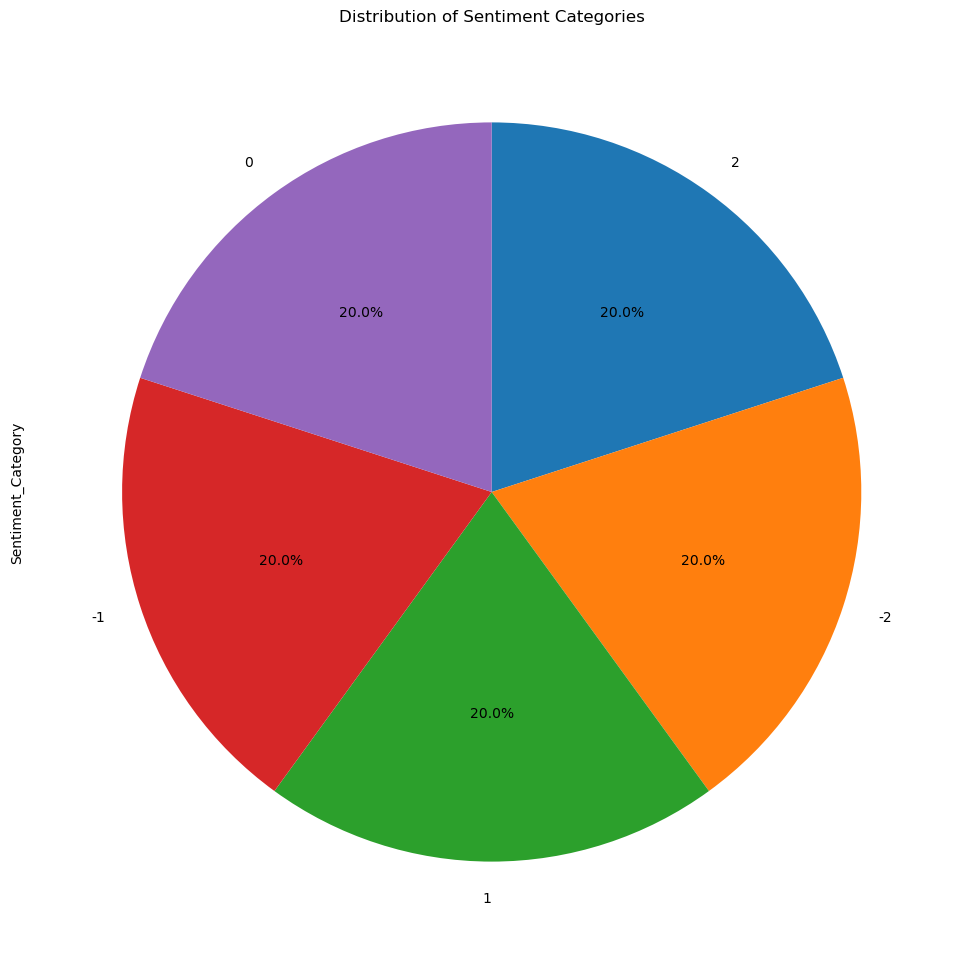

In [67]:
import matplotlib.pyplot as plt
import seaborn as sns

# Assuming 'df' is your DataFrame containing the sentiment categories
# If you haven't already loaded the DataFrame, make sure to do so

plt.figure(figsize=(12, 12))
balanced_data['Sentiment_Category'].value_counts().plot.pie(autopct='%1.1f%%', startangle=90, counterclock=False)
plt.title('Distribution of Sentiment Categories')
plt.show()


In [68]:
from sklearn.feature_extraction.text import CountVectorizer

# Assuming 'df' is your DataFrame with preprocessed text
# If you haven't already loaded the DataFrame, make sure to do so

# Choose the top N words to display
top_n = 10

# Initialize CountVectorizer
vectorizer = CountVectorizer(stop_words='english')

# Fit and transform the text data
X = vectorizer.fit_transform(df['Review'])

# Create a DataFrame with the top N words for each sentiment category
top_words_df = pd.DataFrame(X.toarray(), columns=vectorizer.get_feature_names_out())
top_words_df['Sentiment_Category'] = df['Sentiment_Category']

# Plot the bar chart for each sentiment category
plt.figure(figsize=(15, 8))
for i, sentiment in enumerate(sentiments, 1):
    plt.subplot(2, 3, i)
    subset = top_words_df[top_words_df['Sentiment_Category'] == sentiment]
    top_words = subset.drop('Sentiment_Category', axis=1).sum().sort_values(ascending=False).head(top_n)
    top_words.plot(kind='bar', color='skyblue')
    plt.title(f'Top {top_n} Words - Sentiment {sentiment}')
    plt.xlabel('Word')
    plt.ylabel('Frequency')

plt.tight_layout()
plt.show()


NameError: name 'sentiments' is not defined

<Figure size 1500x800 with 0 Axes>